# This tutorial compares clustering performance of three scenarios: 
 (1) normal (without stSME) 
 
 (2) stSME applied on dimension reduced spaces (PCA) as normalization and 
 
 (3) stSME applied on raw gene counts as imputation

### We ues Human Brain dorsolateral prefrontal cortex (DLPFC) Visium dataset from [here](https://github.com/LieberInstitute/HumanPilot)

In [1]:
# load modules
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scanpy
from pathlib import Path
import stlearn as st

In [2]:
# specify parameters
tile_size = 40
radius = 90.0
rates = 5

# all samples in this dataset
sample_list = ["151507", "151508", "151509",
               "151510", "151669", "151670",
               "151671", "151672", "151673",
               "151674", "151675", "151676"]

In [3]:
# specify PATH
i = 1
sample = sample_list[i]
BASE_PATH = Path("/90days/uqxtan9/Human_Brain_spatialLIBD")
MARKER_GENE_PATH = BASE_PATH / "marker_gene.tsv"
SAMPLE_PATH = BASE_PATH / sample
CM_PATH = BASE_PATH / sample / "{}_filtered_feature_bc_matrix.h5".format(sample)
IMG_PATH = BASE_PATH / sample / "{}_tissue_hires_image.png".format(sample)
SPOT_PATH = BASE_PATH / sample / "tissue_positions_list.txt"
SCALE_PATH = BASE_PATH / sample / "scalefactors_json.json"
TILE_PATH = BASE_PATH / "{}_tiles".format(sample)
TILE_PATH.mkdir(parents=True, exist_ok=True)
MARKER_GENE_PATH = BASE_PATH / "marker_gene.tsv"
GROUND_TRUTH_PATH = BASE_PATH / sample / "cluster_labels_{}.csv".format(sample)

In [4]:
# load ST data and ground truth label for each spot
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH, sep=',', index_col=0)
ground_truth_df.index = ground_truth_df.index.map(lambda x: x[7:])

marker_gene_df = pd.read_csv(MARKER_GENE_PATH, sep='\t')
marker_gene = [i.upper() for i in marker_gene_df["symbol"].to_list()]

data = st.Read10X(SAMPLE_PATH)
data = data[:, marker_gene]

ground_truth_df = ground_truth_df.reindex(data.obs_names)
    
n_cluster = len((set(ground_truth_df["ground_truth"])))
    
data.obs['ground_truth'] = ground_truth_df["ground_truth"]

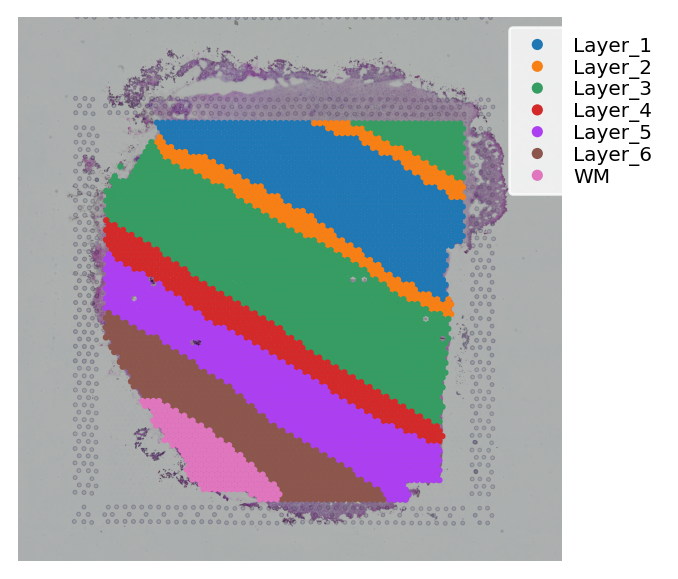

In [5]:
# ground truth label
st.pl.cluster_plot(data, use_label="ground_truth")

In [6]:
# pre-processing for gene count table
st.pp.normalize_total(data)
st.pp.log1p(data)
st.pp.scale(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


### (1) normal (without stSME) 

In [7]:
# run PCA for gene expression data
st.em.run_pca(data, n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


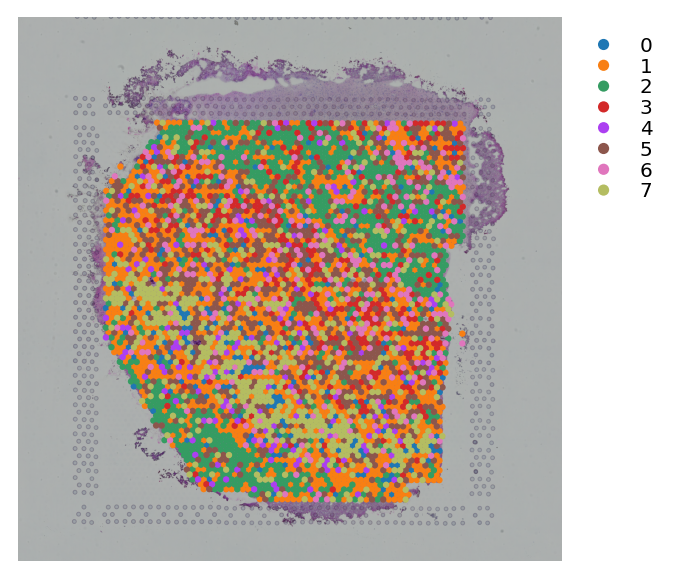

In [8]:
# K-means clustering on PCA
st.tl.clustering.kmeans(data, n_clusters=n_cluster, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data, use_label="X_pca_kmeans")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


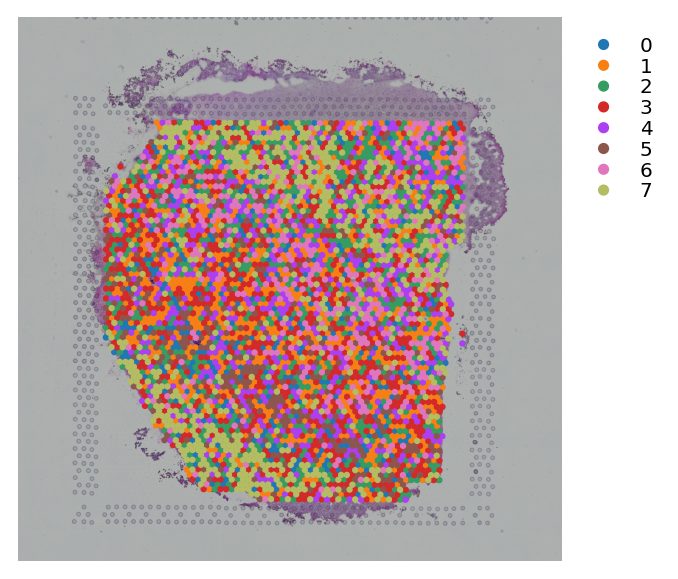

In [9]:
# K-means clustering on UMAP
st.pp.neighbors(data, n_neighbors=15)
st.em.run_umap(data)
st.tl.clustering.kmeans(data, n_clusters=n_cluster, use_data="X_umap", key_added="X_umap_kmeans")
st.pl.cluster_plot(data, use_label="X_umap_kmeans")

### (2) stSME applied on dimension reduced spaces (PCA) as normalization

In [10]:
# pre-processing for spot image
st.pp.tiling(data, TILE_PATH, crop_size=tile_size)

# this step uses deep learning model to extract high-level features from tile images
# may need few minutes to be completed
st.pp.extract_feature(data)

# apply stSME to normalise PCA
# radius=90 includes three units of surrounding spots
st.spatial.morphology.adjust(data, use_data="X_pca", radius=radius, method="mean", 
                             similarity_matrix="cosine", rates=rates)
data.obsm['X_pca'] = data.obsm['X_pca_morphology']

The morphology feature is added to adata.obsm['X_morphology']!
The data adjusted by morphology is added to adata.obsm['X_pca_morphology']


Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


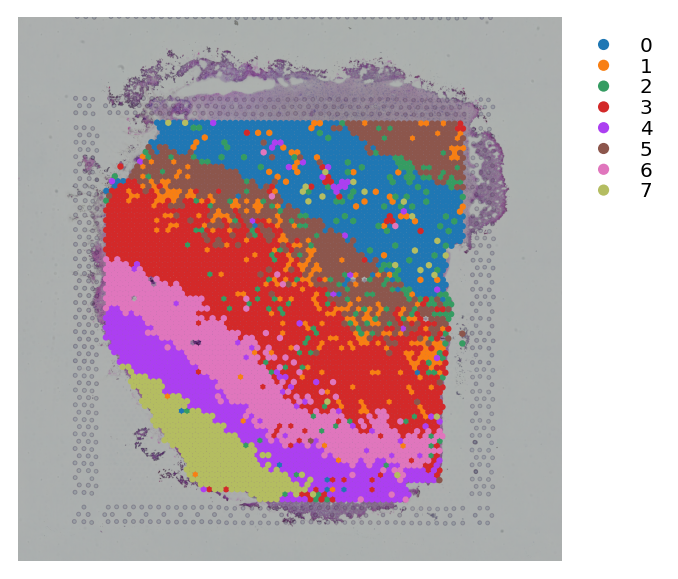

In [11]:
# K-means clustering on stSME normalised PCA
st.tl.clustering.kmeans(data, n_clusters=n_cluster, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data, use_label="X_pca_kmeans")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


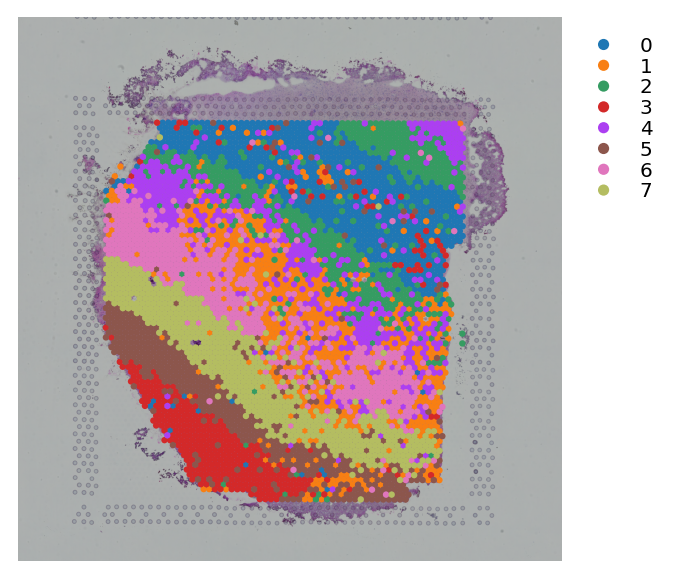

In [12]:
# K-means clustering on stSME normalised UMAP
st.pp.neighbors(data, n_neighbors=15)
st.em.run_umap(data)
st.tl.clustering.kmeans(data, n_clusters=n_cluster, use_data="X_umap", key_added="X_umap_kmeans")
st.pl.cluster_plot(data, use_label="X_umap_kmeans")

### (3) stSME applied on raw gene counts as imputation

In [13]:
# apply stSME to raw counts
# radius=90 includes three units of surrounding spots
st.spatial.morphology.adjust(data, use_data="raw", radius=radius, method="mean", 
                             similarity_matrix="cosine", rates=rates)
data.X = data.obsm['raw_morphology']

The data adjusted by morphology is added to adata.obsm['raw_morphology']


In [14]:
st.em.run_pca(data, n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


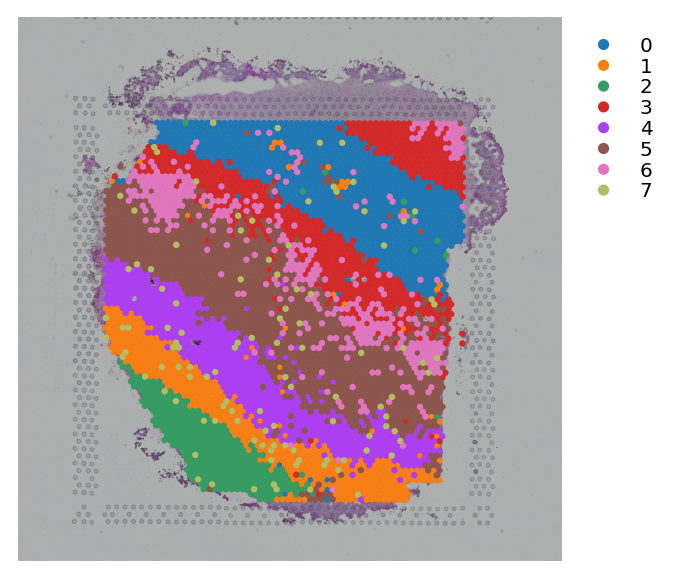

In [15]:
st.tl.clustering.kmeans(data, n_clusters=n_cluster, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data, use_label="X_pca_kmeans")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


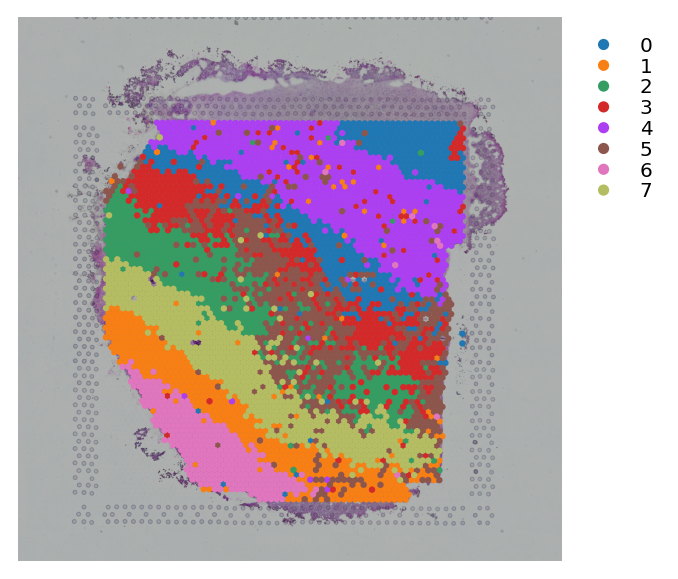

In [16]:
st.pp.neighbors(data, n_neighbors=15)
st.em.run_umap(data)
st.tl.clustering.kmeans(data, n_clusters=n_cluster, use_data="X_umap", key_added="X_umap_kmeans")
st.pl.cluster_plot(data, use_label="X_umap_kmeans")